In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvokumarbasakbd/brain-stroke-dataset-colorized-teknofest-2021")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-stroke-dataset-colorized-teknofest-2021


In [ ]:
import cv2
import pandas
import numpy as np
import random
import os
from PIL import Image , ImageEnhance
import matplotlib.pyplot as plt


#model building
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Flatten , Dropout , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

from sklearn.utils import shuffle

In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
test_p = "/kaggle/input/brain-stroke-dataset-colorized-teknofest-2021/dataset/test"
train_p = "/kaggle/input/brain-stroke-dataset-colorized-teknofest-2021/dataset/train"

In [ ]:
def shuff(X):
  path = []
  label = []
  for i in os.listdir(X):
    for img in os.listdir(os.path.join(X,i)):
      path.append(os.path.join(X,i,img))
      label.append(i)
  path , label = shuffle(path,label)
  return path , label

In [ ]:
train_paths , train_labels = shuff(train_p)
test_paths , test_labels = shuff(test_p)
print(sorted(os.listdir(train_p)))

['Kanama', 'YarısmaVeriSeti_1_Oturum', 'YarısmaVeriSeti_2_Oturum', 'İnme Yok', 'İskemi']


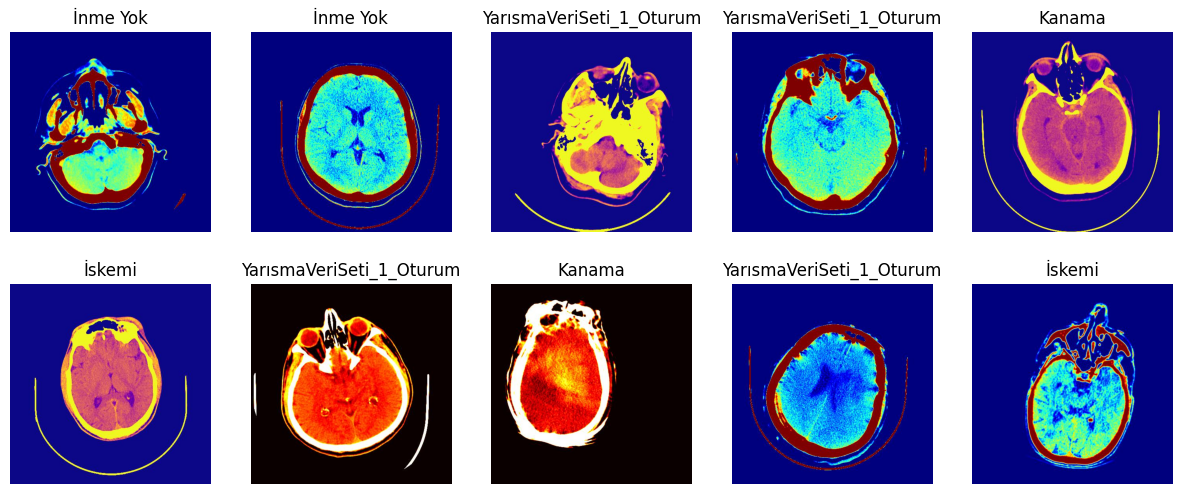

In [ ]:
#select 10 random images
rand_ind = random.sample(range(0,len(train_paths)),10)
#create images
fig,axis = plt.subplots(2,5,figsize=(15,6))
axis = axis.ravel()
for i in range(0,10):
  img = cv2.imread(train_paths[rand_ind[i]])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  axis[i].imshow(img)
  axis[i].axis("off")
  axis[i].set_title(train_labels[rand_ind[i]])
plt.show()

In [ ]:
for i in range(0, 10):
    img = cv2.imread(train_paths[rand_ind[i]])
    print(f"Image {i+1} shape: {img.shape}")

Image 1 shape: (512, 512, 3)
Image 2 shape: (512, 512, 3)
Image 3 shape: (512, 512, 3)
Image 4 shape: (512, 512, 3)
Image 5 shape: (512, 512, 3)
Image 6 shape: (512, 512, 3)
Image 7 shape: (512, 512, 3)
Image 8 shape: (512, 512, 3)
Image 9 shape: (512, 512, 3)
Image 10 shape: (512, 512, 3)


In [ ]:
#Image Preprocessing
def augmented_img(img):
  if img is None:
    return None  # Return None if image loading failed
  img = Image.fromarray(np.uint8(img))
  img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8,1.2))
  img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8,1.2))
  img = np.array(img).astype(np.float32) / 255.0
  return img


#load img
# def open_img(paths):
#   images = []
#   for path in paths:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     augmented = augmented_img(img)
#     if augmented is not None:
#       images.append(augmented)
#   return np.array(images)

def open_img(paths):
    images = []
    for path in paths:
        try:
            # Read and resize image
            img = cv2.imread(path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_siz, img_siz))  # Enforce model input size

            # Apply augmentation
            augmented = augmented_img(img)
            if augmented is not None:
                images.append(augmented)

        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            continue

    return np.array(images)  # Now all images will be (128,128,3)


#encoder labels (lanbel names->int)
def label_enco(lab):
  uni_lab = sorted(os.listdir(train_p))
  enco = [uni_lab.index(i) for i in lab] # Encode the input labels, not unique labels
  return enco

#data generatior for batching
# def data_gen(path,label,batch_size=12,epochs=2):
#   for _ in range(epochs):
#     for i in range(0,len(path),batch_size):
#       batch_paths = path[i:i+batch_size]
#       batch_img = open_img(batch_paths)
#       batch_lab = label_enco(label[i:i+batch_size])
#       yield batch_img , batch_lab




def data_gen(path, label, batch_size=12, epochs=2):
    for _ in range(epochs):
        for i in range(0, len(path), batch_size):
            batch_paths = path[i:i+batch_size]
            batch_img = open_img(batch_paths)
            batch_lab = label_enco(label[i:i+batch_size])
            if len(batch_img) > 0:
                yield batch_img, np.array(batch_lab)  #

In [ ]:
#Model Architecture

img_siz = 250
OG_model= VGG19(input_shape=(img_siz,img_siz,3),weights="imagenet",include_top=False)

#freeze all layers of VGG19
for i in OG_model.layers:
  i.trainable = False

OG_model.layers[-2].trainable = True
OG_model.layers[-3].trainable = True
OG_model.layers[-4].trainable = True

#build model stck models in seq
model = Sequential()
model.add(Input(shape=(img_siz,img_siz,3)))
model.add(OG_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(img_siz,activation="relu")) #not final but fully connected dense layer
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_p)),activation="softmax")) #output later

#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

batch_siz = 20
steps = len(train_paths) // batch_siz # Corrected steps_per_epoch calculation
epoch = 15

#fit model
history = model.fit(data_gen(train_paths,train_labels,batch_size=batch_siz,epochs=epoch),
                    steps_per_epoch=steps,epochs=epoch,verbose=1)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 67s 202ms/step - loss: 1.6311 - sparse_categorical_accuracy: 0.2651
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - loss: 1.2046 - sparse_categorical_accuracy: 0.5117
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.7986 - sparse_categorical_accuracy: 0.6928
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - loss: 0.5094 - sparse_categorical_accuracy: 0.8008
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.8671
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.9016
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - loss: 0.2180 - sparse_categorical_accuracy: 0.9256
Epoch 8/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.1919 - sparse_categorical_accuracy: 0.9371
Epoch 9/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9405
Epoch 10/15
248/248 ━━━━━━━━

In [ ]:
test_gen = data_gen(train_paths, train_labels, batch_size=batch_siz)
x_batch, y_batch = next(test_gen)
print(f"Batch shape: {x_batch.shape}")

Batch shape: (20, 250, 250, 3)


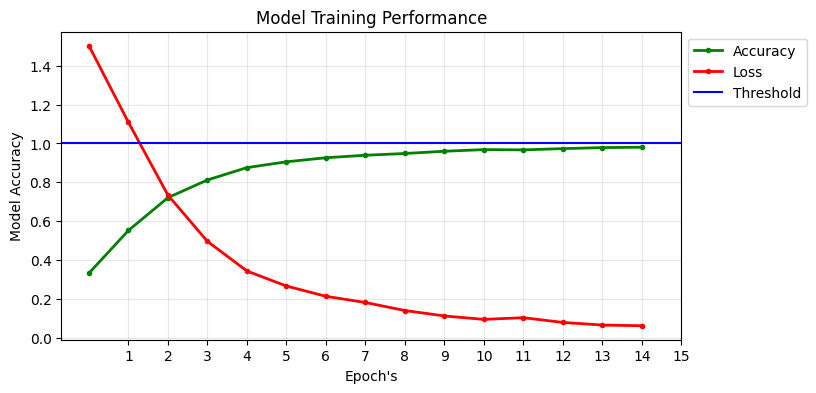

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["sparse_categorical_accuracy"],'.g-',linewidth=2)
plt.plot(history.history["loss"],'.r-',linewidth=2)
plt.axhline(y=1, color='blue', linestyle='-', linewidth=1.5, label='Threshold = 1')


plt.title("Model Training Performance")
plt.xlabel("Epoch's")
plt.ylabel("Model Accuracy")
plt.xticks([i for i in range(1,epoch+1)])
plt.legend(['Accuracy','Loss','Threshold'],loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True, alpha=0.3)
plt.show()

###Model Report

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , auc
import seaborn as sb
from sklearn.preprocessing import label_binarize

In [ ]:
test_img = open_img(test_paths)
print(test_img.shape)

test_label_enco = label_enco(test_labels)

test_pred = model.predict(test_img)
print("Classificaton Report")
print(classification_report(test_label_enco,np.argmax(test_pred , axis=1)))

(800, 250, 250, 3)
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step
Classificaton Report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       200
           1       0.75      0.91      0.82       200
           2       0.00      0.00      0.00         0
           3       0.80      0.71      0.75       200
           4       0.93      0.81      0.87       200

    accuracy                           0.81       800
   macro avg       0.67      0.65      0.66       800
weighted avg       0.84      0.81      0.82       800



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[165  14   6  10   5]
 [  5 182   2  11   0]
 [  0   0   0   0   0]
 [ 10  38   3 142   7]
 [ 12   9   2  14 163]]


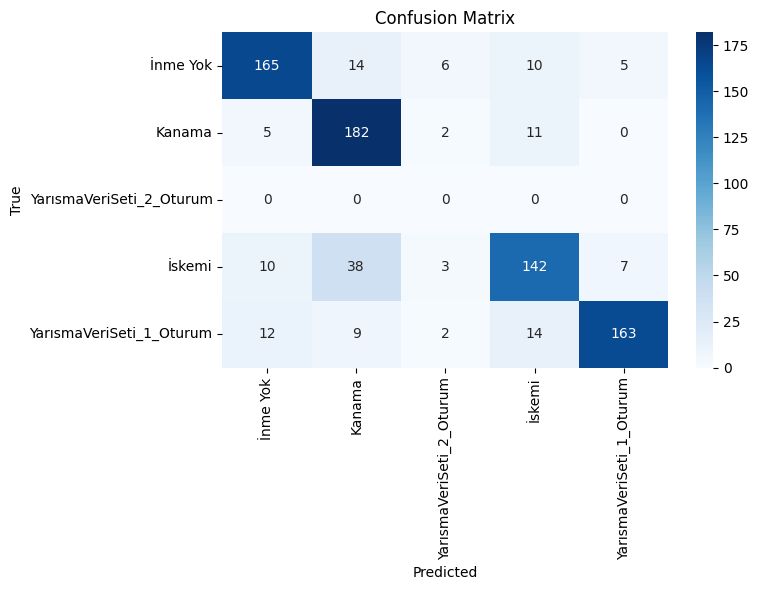

In [ ]:
conf_maatrix = confusion_matrix(test_label_enco,np.argmax(test_pred , axis=1))
print("Confusion Matrix:")
print(conf_maatrix)

# plt.figure(figsize=(8,6))
# sb.heatmap(confusion_matrix, annot=True,  fmt='d', cmap='Blues' ,xticklabels = os.listdir(train_p),yticklabels = os.listdir(train_p))
# plt.xlabel("Predicted")
# plt.ylabel("true")

plt.figure(figsize=(8, 6))
sb.heatmap(conf_maatrix,  # Use your variable, not the function name
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=os.listdir(train_p),
           yticklabels=os.listdir(train_p))

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

##ROC Curve

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


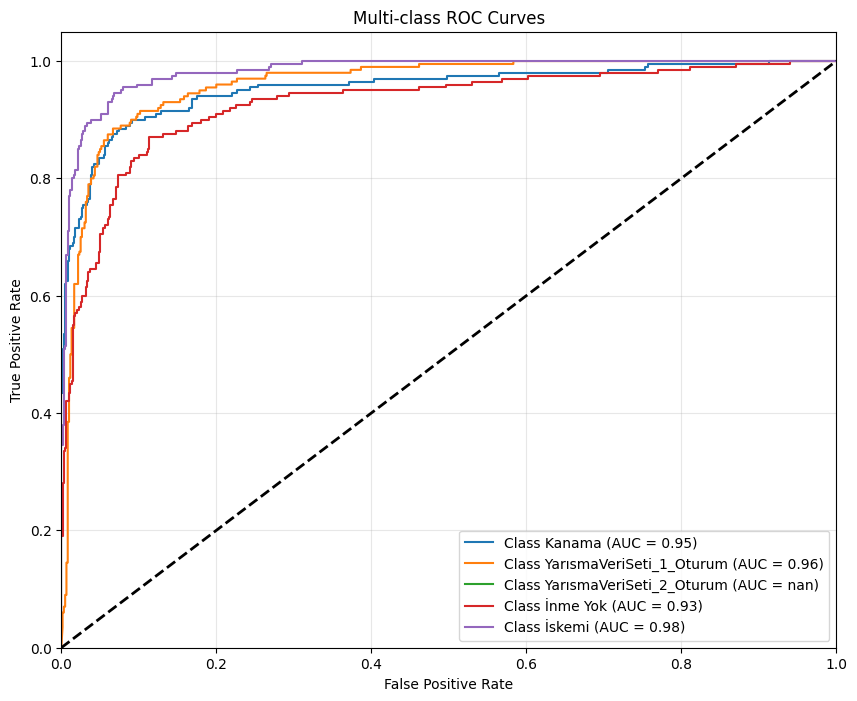

In [ ]:
# ROC Curve Implementation
def plot_roc_curve(y_true, y_pred_prob, class_names):
    """
    Plot ROC curve for multi-class classification

    Parameters:
    y_true (array): True labels (integer encoded)
    y_pred_prob (array): Predicted probabilities for each class
    class_names (list): List of class names
    """
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Plot each class ROC curve
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i],
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot random guessing line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Get class names and predicted probabilities
class_names = sorted(os.listdir(train_p))
y_pred_prob = model.predict(test_img)

# Plot ROC curve
plot_roc_curve(test_label_enco, y_pred_prob, class_names)


In [ ]:
model.save("model.h5")

###Manual Validation

In [ ]:
from keras.models import load_model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = sorted(os.listdir(train_p))

def model_detect_disp(img_path,model=model):
  try:
    # Load and preprocess image
    img = load_img(img_path, target_size=(250, 250))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    predicted_class = class_labels[predicted_class_idx]

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
    plt.show()

    # return predicted_class, confidence
  except Exception as e:
    print("Error :",str(e))


10052_4_k.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


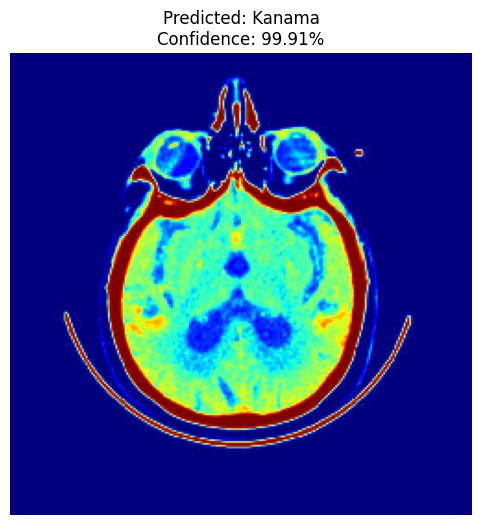

10017_2i.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


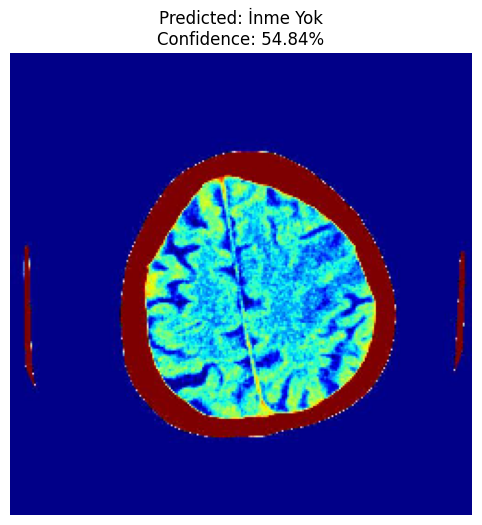

10007_10y.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


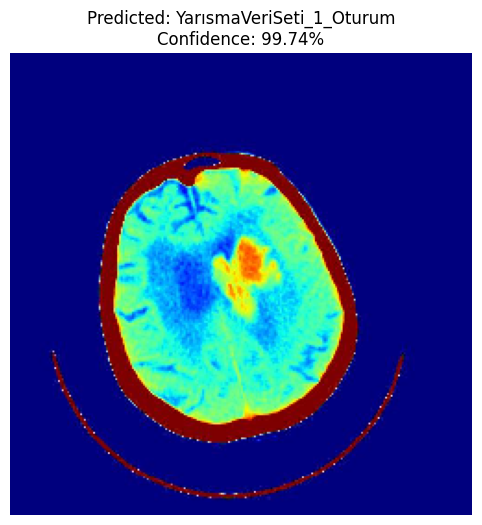

10008_8n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


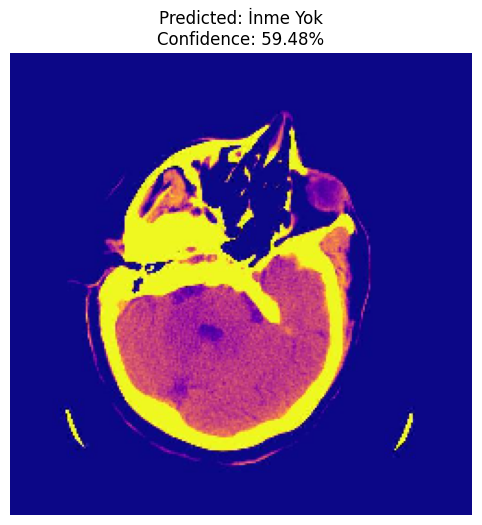

In [ ]:
for i in os.listdir("/content/Manual Testing"):
  print(i)
  model_detect_disp("/content/Manual Testing/"+i,model)

In [ ]:
\